In [217]:
import numpy as np
import matplotlib.pyplot as plt
from mcmcrotation import read_file

%matplotlib inline

import celerite
from celerite import terms

from scipy.optimize import minimize

In [218]:
fns = glob.glob('../data/*.csv')
fn = fns[0]
df = read_file(fn)



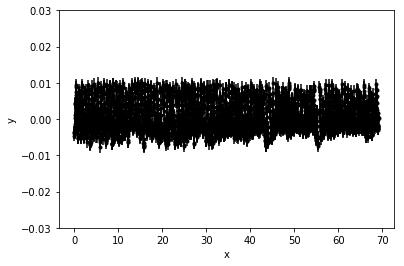

In [346]:
mask = (df.time < 75) & np.abs(df.flux < 0.01) & np.isfinite(df.flux)
t = df.loc[mask, 'time']
y = df.loc[mask, 'flux']
yerr = df.loc[mask, 'ferr'] *5

# plt.plot(t, yerr, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
# plt.xlim(0, 10)
plt.ylim(-0.03, 0.03);

In [347]:
# # A non-periodic component
# Q = 1.0 / np.sqrt(2.0)
# w0 = 3.0
# S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
# kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                        bounds=bounds)
# kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# # A periodic component
# Q = 1.0
# w0 = 3.0
# S0 = np.var(y) / (w0 * Q)
# kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                         bounds=bounds)

# A periodic component
Q = 50
w0 = np.pi *2
S0 = 0.1
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
# kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

In [348]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: 7007.458453745601


In [349]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:log_S0', -2.3025850929940455), ('kernel:log_Q', 3.912023005428146), ('kernel:log_omega0', 1.8378770664093453)])

parameter_names:
('kernel:log_S0', 'kernel:log_Q', 'kernel:log_omega0')

parameter_vector:
[-2.30258509  3.91202301  1.83787707]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15)]



In [350]:


def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -12987.150155999945
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 10.22071956,  13.51945684,   6.07396942])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 4
   status: 0
  success: True
        x: array([-3.48540614,  3.41974639,  0.26963941])


In [351]:
print('period = {}'.format((np.pi * 2) / np.exp(gp.get_parameter_dict()['kernel:log_omega0'])))
print('S0 = {}'.format((np.exp(gp.get_parameter_dict()['kernel:log_S0']))))

period = 4.798184711255352
S0 = 0.03064131131713306


In [352]:
x = np.linspace(0, 50, 3000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

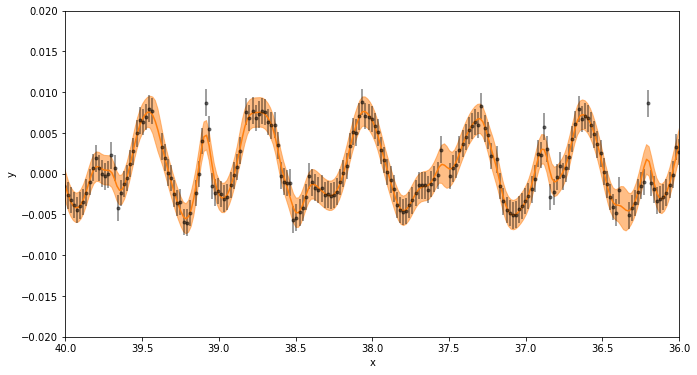

In [353]:
fig, ax = plt.subplots(1,1,figsize=[11,6], )

color = "#ff7f0e"
# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.5)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+(2*pred_std), pred_mean-(2*pred_std), color=color, alpha=0.5,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(40, 36)
plt.ylim(-0.02, 0.02);

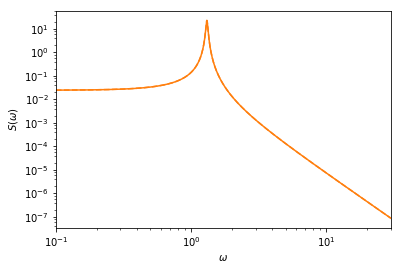

In [354]:
omega = np.exp(np.linspace(np.log(0.1), np.log(30), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");